In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from enum import Enum
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import numpy as np
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
from torch.utils.tensorboard import SummaryWriter
import random
from PIL import Image
import gc

%load_ext tensorboard

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [2]:
!pip install open_clip_torch

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install nltk sacrebleu
# !pip install py-meteor
!pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.9 MB/s eta 0:00:00:00:0100:01


In [4]:
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class ClipCocoDataset(Dataset):

    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

    def __init__(self, data_path: str,  prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image_id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]
        if os.path.isfile(f"{data_path[:-4]}_tokens.pkl"):
            with open(f"{data_path[:-4]}_tokens.pkl", 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0
            for caption in captions_raw:
                self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption['caption']), dtype=torch.int64))
                self.caption2embedding.append(caption["clip_embedding"])
                max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
            with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))



In [5]:
class Flickr30kImagesDataset(Dataset):
    # Initialize CLIP model and preprocessing transforms
    # clip_model, _, clip_preprocess = create_model_and_transforms(
    #     'ViT-bigG-14-quickgelu', pretrained='metaclip_fullcc', device='cuda'
    # )
    # clip_model.eval()  # Set to evaluation mode
    
    # def __init__(self, image_dir: str, captions_df: pd.DataFrame, prefix_length: int, normalize_prefix=False):
    #     """
    #     image_dir: Path to the directory containing images.
    #     captions_df: DataFrame with 'image' and 'caption' columns.
    #     prefix_length: Length of the prefix for the embeddings.
    #     normalize_prefix: Whether to normalize the CLIP embeddings.
    #     """
    #     self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    #     self.prefix_length = prefix_length
    #     self.normalize_prefix = normalize_prefix

    #     # Precompute tokens and CLIP embeddings
    #     self.caption_tokens = []
    #     self.caption2embedding = []
    #     self.max_seq_len = 0
    #     self._precompute_embeddings_and_tokens(image_dir, captions_df)

    # def _precompute_embeddings_and_tokens(self, image_dir, captions_df):
    #     """Precomputes tokens for captions and CLIP embeddings for images."""
    #     for idx, row in tqdm(captions_df.iterrows()):
    #         image_filename = row['image']
    #         caption = row['caption']

    #         # Tokenize caption
    #         tokens = torch.tensor(self.tokenizer.encode(caption), dtype=torch.int64)
    #         self.caption_tokens.append(tokens)
    #         self.max_seq_len = max(self.max_seq_len, tokens.shape[0])

    #         # Process image to get CLIP embedding
    #         # image_path = os.path.join(image_dir, image_filename)
    #         # image = Image.open(image_path)
    #         # image_tensor = self.clip_preprocess(image).unsqueeze(0)  # Add batch dimension

    #         # with torch.no_grad():
    #         #     embedding = self.clip_model.encode_image(image_tensor).squeeze(0)
    #         # if self.normalize_prefix:
    #         #     embedding = embedding / embedding.norm(2, -1)
    #         # self.caption2embedding.append(embedding)

    #         if idx % 5 == 0:
    #         # Process image to get CLIP embedding
    #             image_path = os.path.join(image_dir, image_filename)
    #             image = Image.open(image_path)
    #             image_tensor = Flickr30kImagesDataset.clip_preprocess(image).unsqueeze(0).to('cuda')  # Add batch dimension
    
    #             with torch.no_grad():
    #                 embedding = Flickr30kImagesDataset.clip_model.encode_image(image_tensor).squeeze(0)
    #             if self.normalize_prefix:
    #                 embedding = embedding / embedding.norm(2, -1)
    #             self.caption2embedding.append(embedding)
    #         else:
    #             self.caption2embedding.append(self.caption2embedding[-1].clone())

    def pad_tokens(self, idx):
        """Pads tokens to the maximum sequence length and creates a mask."""
        tokens = self.caption_tokens[idx]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.caption_tokens[idx] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.caption_tokens[idx] = tokens
        mask = tokens.ge(0)  # Mask is zero where we are out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # Add prefix mask
        return tokens, mask

    def __len__(self):
        return len(self.caption_tokens)

    def __getitem__(self, idx):
        tokens, mask = self.pad_tokens(idx)
        prefix_embedding = self.caption2embedding[idx]
        return tokens, mask, prefix_embedding

    def to_pickle(self, pickle_path: str):
        """Saves the dataset information, including caption tokens, embeddings, and parameters, to a pickle file."""
        with open(pickle_path, 'wb') as f:
            pickle.dump({
                'caption_tokens': self.caption_tokens,
                'caption2embedding': self.caption2embedding,
                'max_seq_len': self.max_seq_len,
                'prefix_length': self.prefix_length,
                'normalize_prefix': self.normalize_prefix
            }, f)

    @classmethod
    def from_pickle(cls, pickle_path: str):
        """Loads the dataset information, including caption tokens, embeddings, and parameters, from a pickle file."""
        with open(pickle_path, 'rb') as f:
            data = pickle.load(f)
        dataset = cls.__new__(cls)  # Create an uninitialized instance
        dataset.caption_tokens = data['caption_tokens']
        dataset.caption2embedding = data['caption2embedding']
        dataset.max_seq_len = data['max_seq_len']
        dataset.prefix_length = data['prefix_length']
        dataset.normalize_prefix = data['normalize_prefix']
        return dataset


In [6]:
class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MlpTransformer(nn.Module):
    def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
        super().__init__()
        out_d = out_d if out_d is not None else in_dim
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.act = act
        self.fc2 = nn.Linear(h_dim, out_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention

In [7]:
class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)


In [8]:
class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self


In [9]:
def save_config(args: argparse.Namespace):
    config = {}
    for key, item in args._get_kwargs():
        config[key] = item
    out_path = os.path.join(out_dir, f"{args.prefix}.json")
    with open(out_path, 'w') as outfile:
        json.dump(config, outfile)


def load_model(config_path: str, epoch_or_latest: Union[str, int] = '_latest'):
    with open(config_path) as f:
        config = json.load(f)
    parser = argparse.ArgumentParser()
    parser.set_defaults(**config)
    # args = parser.parse_args()
    if type(epoch_or_latest) is int:
        epoch_or_latest = f"-{epoch_or_latest:03d}"
    model_path = os.path.join(args.out_dir, f"{args.prefix}{epoch_or_latest}.pt")
    if only_prefix:
        model = ClipCaptionPrefix(prefix_length)
    else:
        model = ClipCaptionModel(prefix_length)
    if os.path.isfile(model_path):
        print(f"loading model from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    else:
        print(f"{model_path} is not exist")
    return model, parser


def train(dataset, model: ClipCaptionModel, batch_size, epochs , train_dataloader, val_dataloader,
          lr: float = 2e-5 , 
          warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = "", save_every = 1):
    writer = SummaryWriter()
    device = torch.device('cuda:0')
    batch_size = batch_size
    epochs = epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        loss_train = None
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss_train = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss_train.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss_train": loss_train.item()})
            progress.update()
            # break
            # if (idx + 1) % 10000 == 0:
            #     torch.save(
            #         model.state_dict(),
            #         os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                # )
        progress.close()
        # writer.add_scalar("Loss/train", loss_train, epoch)
        # writer.flush()
        # if epoch % save_every == 0 or epoch == epochs - 1:
        torch.save(
            model.state_dict(),
            f"{output_prefix}-epoch-{epoch:03d}-lossTrain-{loss_train:0.3f}.pt" )


        #evaluate
        
        model.eval()
        loss_val = 0.0
        with torch.no_grad():
            for idx, (tokens, mask, prefix) in enumerate(val_dataloader):
                tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
                outputs = model(tokens, prefix, mask)
                logits = outputs.logits[:, dataset.prefix_length - 1: -1]
                loss_val += nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0).item()

                # break
        # Average validation loss
        loss_val /= len(val_dataloader)
        writer.add_scalar("Loss/train", loss_train.item(), epoch)
        writer.add_scalar("Loss/val", loss_val, epoch)
        writer.flush()
        
    writer.close()
    return model

In [10]:

out_dir = './checkpoints'
# dataset = ClipCocoDataset(args.data, prefix_length, normalize_prefix=args.normalize_prefix)
data = '/kaggle/input/flickr-pickle-format/Flickr30kImagesDatasetSaveFinal'
dataset = Flickr30kImagesDataset.from_pickle(data)
prefix_length = 5
dataset.prefix_length = prefix_length
# prefix_dim = 640 if args.is_rn else 512
prefix_dim = 1280

In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 60
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [12]:
# mapping_type = {'mlp': MappingType.MLP, 'transformer': MappingType.Transformer}['mlp']
# only_prefix = False
# if only_prefix:
#     model = ClipCaptionPrefix(prefix_length, clip_length=5, prefix_size=prefix_dim,
#                               num_layers=8, mapping_type=mapping_type)
#     print("Train only prefix")
# else:
#     model = ClipCaptionModel(prefix_length, clip_length=5, prefix_size=prefix_dim,
#                               num_layers=8, mapping_type=mapping_type)
#     print("Train both prefix and GPT")
#     # sys.stdout.flush()


# train(dataset, model, batch_size = batch_size, train_dataloader = train_dataloader, val_dataloader = val_dataloader, epochs=10 , output_dir="./checkpoints", output_prefix='Flickr30k')

In [13]:


# model_big_prefix_length = ClipCaptionModel(prefix_length=40, clip_length=5, prefix_size=1280,
#                                   num_layers=8, mapping_type=MappingType.MLP)
# model_big_prefix_length.load_state_dict(torch.load('/kaggle/input/clipcap-different-versions/Flickr30k-epoch-002-lossTrain-2.107.pt', map_location='cpu'))

# model_big_prefix_length = model_big_prefix_length.eval()
# model_big_prefix_length = model_big_prefix_length.to(device)
# model_big_prefix_length.eval()

In [14]:

torch.cuda.empty_cache()
gc.collect()

528

In [15]:


model_big_batch = ClipCaptionModel(prefix_length=5, clip_length=5, prefix_size=1280,
                                  num_layers=8, mapping_type=MappingType.MLP)
model_big_batch.load_state_dict(torch.load('/kaggle/input/clipcap-different-versions/Flickr30k-epoch-004-lossTrain-2.117.pt', map_location='cpu'))

model_big_batch = model_big_batch.eval()
model_big_batch = model_big_batch.to(device)
model_big_batch.eval()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-15-37cd7393d02d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_big_batch.load_state_dict(torch.load('/kaggle/input/clipcap-different-versions/Flickr3

ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (clip_project): MLP(
    (m

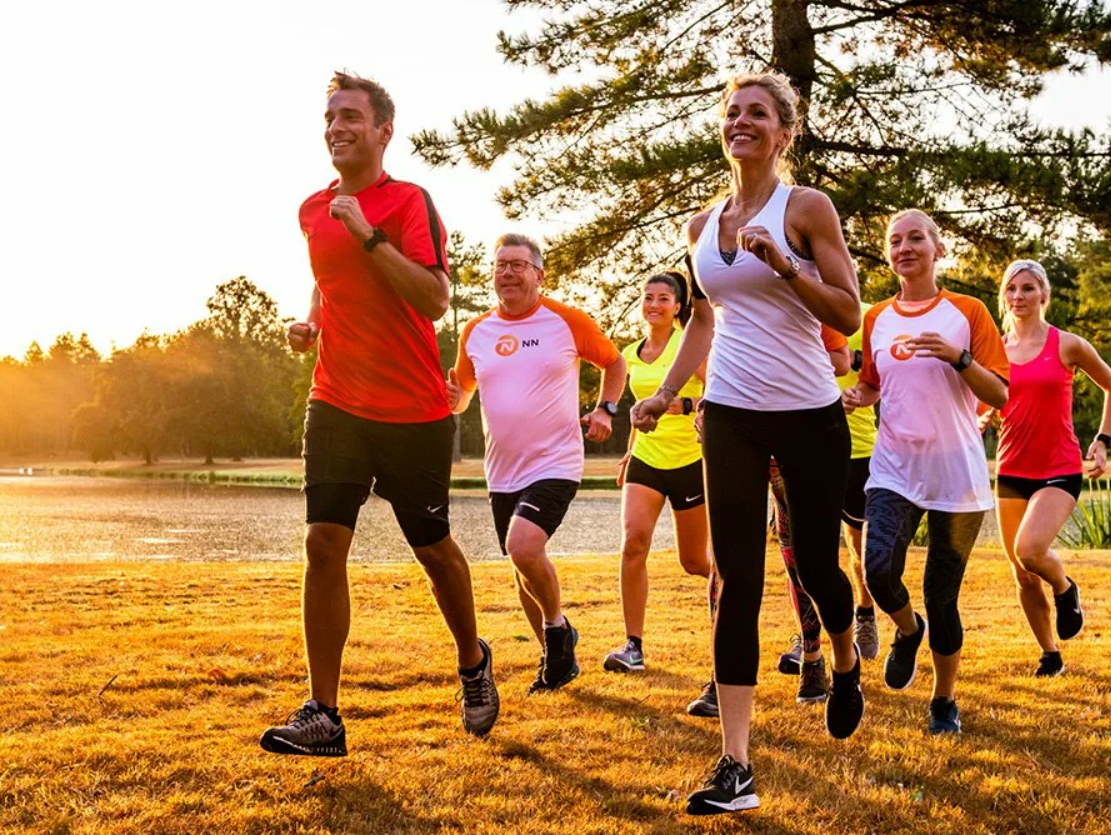

In [16]:
import requests

img_url = 'https://static.tildacdn.com/tild6231-3330-4139-a431-633439643563/image.png'
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
image

In [17]:
from open_clip.factory import create_model_and_transforms
clip_model, _, preprocess = create_model_and_transforms(
    'ViT-bigG-14-quickgelu', pretrained='metaclip_fullcc', device=device
)

open_clip_model.safetensors:   0%|          | 0.00/10.2G [00:00<?, ?B/s]

In [18]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [22]:
def predict_image_caption(image, model): 
    images = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prefix = clip_model.encode_image(images).to(device, dtype=torch.float32)
        # prefix = prefix / prefix.norm(2, -1).item()
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
    
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    generated_text_prefix = generate_beam(model, tokenizer, beam_size=7,embed=prefix_embed,stop_token='<|endoftext|>',entry_length=30)[0]
    
    return (generated_text_prefix)

predict_image_caption(image, model_big_batch )

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


'A group of men and women are running in a park with trees in the background..............'

In [20]:
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

test_gt = ['A group of men and women are running in a park with trees in the background..............',
           ' in a park ....']

score = sentence_bleu(test_gt[0], test_gt[1], smoothing_function=SmoothingFunction().method1)
print(f'BLEU Score: {score:.4f}')

references = {
    'image1': ['a cat is sitting on a mat', 'a kitty sits on a rug']
}
# Описание модели
hypotheses = {
    'image1': ['a cat is on the mat']
}

cider = Cider()
cider_score, _ = cider.compute_score(references, hypotheses)
print(f'CIDEr Score: {cider_score:.4f}')

# SPICE
spice = Spice()
spice_score, _ = spice.compute_score(references, hypotheses)
print(f'SPICE Score: {spice_score:.4f}')

BLEU Score: 0.0222
CIDEr Score: 0.0000
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
SPICE Score: 0.4444


In [50]:
import string

references = {}
hypos = {}

with torch.no_grad():
        for batch_id, (tokens, mask, prefix) in tqdm(enumerate(val_dataloader)):
            
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)

            outputs = model_big_batch(tokens, prefix)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            
            for i in range(tokens.shape[0]):
            
                
                gt = tokenizer.decode(tokens[i].tolist(), skip_special_tokens=True)
                pred = tokenizer.decode(torch.argmax(logits, dim=-1)[i].tolist(), skip_special_tokens=True)

                image_name = f"image{i}_batch{batch_id}"

                
                references[image_name] = [gt.translate(str.maketrans('', '',
                                    string.punctuation))]
                hypos[image_name] = [pred.translate(str.maketrans('', '',
                                    string.punctuation))]
                # print(tokens[i],tokens[i].shape, mask[i].shape, prefix[i].shape)
                
                
                
                # print( predicted )
               
# for tokens, prefix, mask in val_dataloader:
#     tokens, prefix, mask = tokens.to(device), prefix.to(device), mask.to(device, dtype=torch.float32)
#     print(mask)
#     gt = (tokenizer.decode(tokens[0], skip_special_tokens=True) )
    
#     outputs = model_big_batch(tokens, prefix, mask)
#     # logits = outputs.logits[:, dataset.prefix_length - 1: -1]
#     print(outputs)
#     break

529it [04:41,  1.88it/s]


In [52]:
# references

In [ ]:
cider = Cider()
cider_score, _ = cider.compute_score(references, hypos)
print(f'CIDEr Score: {cider_score:.4f}')


CIDEr Score: 1.2224


In [ ]:

spice = Spice()
spice_score, _ = spice.compute_score(references, hypos)
print(f'SPICE Score: {spice_score:.4f}')

In [ ]:
generated_text_prefix = generate_beam(model_big_batch, tokenizer, beam_size=7,
                                      embed=prefix_embed,stop_token='<|endoftext|>',entry_length=30)[0]
